# 平安银行客户数据分析 (PinAn Bank Customer Data Analysis)

本项目对平安银行客户数据进行全面的数据清洗、分析和可视化

## 分析目标：
1. ✓ 数据加载和初步检查
2. ✓ 数据清洗（处理缺失值、异常值、重复值）
3. ✓ 数据统计和摘要分析
4. ✓ 客户分布分析（地域、类型、风险等级）
5. ✓ 数据导入数据库
6. ✓ 数据可视化分析

In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

# 设置显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print("✓ 所有库导入成功！")

✓ 所有库导入成功！


## 第1步：数据加载和初步检查

In [2]:
# 加载脏数据
data_folder = 'Data'
file_path = os.path.join(data_folder, 'pingan_bank_customers_raw.csv')

df = pd.read_csv(file_path)
print(f"✓ 数据加载成功！")
print(f"数据形状: {df.shape}")
print(f"总行数: {len(df)}, 总列数: {len(df.columns)}")
print(f"\n前5行数据:")
print(df.head())

✓ 数据加载成功！
数据形状: (10200, 9)
总行数: 10200, 总列数: 9

前5行数据:
  customer_id name id_type     id_number        mobile  \
0  PA13356886  郑建平     身份证  4.403012e+18  1.338213e+10   
1  PA83197857   张浩     身份证  5.001012e+18  1.332847e+10   
2  PA90801586   林龙     身份证           NaN  1.313216e+10   
3  PA47338124   赖莹     身份证  1.101012e+18  1.596490e+10   
4  PA38898923   李东     身份证           NaN  1.382194e+10   

                  address   open_date customer_type risk_score  
0     重庆市丹丹市江北袁街G座 408124  2021-07-20            个人         95  
1    河北省海门市淄川拉萨路D座 505353  2025-03-30            个人         38  
2    陕西省邯郸县沙湾澳门路E座 198333  2023-11-01            个人         29  
3  澳门特别行政区勇县西峰王路r座 975096  2025-07-25            个人         54  
4    贵州省北京县秀英长沙路W座 570414  2022-09-24            个人         13  


## 第2步：数据质量检查（识别缺失值、异常值、重复值）

In [3]:
# 检查缺失值
print("=" * 60)
print("【缺失值统计】")
print("=" * 60)
missing_count = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    '列名': missing_count.index,
    '缺失数': missing_count.values,
    '缺失率%': missing_percentage.values
})
print(missing_df[missing_df['缺失数'] > 0].to_string(index=False))
print(f"\n总体缺失率: {df.isnull().sum().sum() / (len(df) * len(df.columns)) * 100:.2f}%")

# 检查重复值
print("\n" + "=" * 60)
print("【重复值统计】")
print("=" * 60)
duplicate_count = df.duplicated().sum()
print(f"完全重复记录数: {duplicate_count}")
print(f"重复率: {duplicate_count / len(df) * 100:.2f}%")

# 按 customer_id 检查重复
duplicate_customer_id = df.duplicated(subset=['customer_id']).sum()
print(f"customer_id 重复数: {duplicate_customer_id}")

# 检查数据类型
print("\n" + "=" * 60)
print("【数据类型检查】")
print("=" * 60)
print(df.dtypes)

# 数据统计摘要
print("\n" + "=" * 60)
print("【基本统计信息】")
print("=" * 60)
print(df.describe(include='all').T)

【缺失值统计】
       列名  缺失数     缺失率%
id_number  709 6.950980
   mobile  708 6.941176
  address  712 6.980392

总体缺失率: 2.32%

【重复值统计】
完全重复记录数: 160
重复率: 1.57%
customer_id 重复数: 200

【数据类型检查】
customer_id       object
name              object
id_type           object
id_number        float64
mobile           float64
address           object
open_date         object
customer_type     object
risk_score        object
dtype: object

【基本统计信息】
                count unique                  top  freq  \
customer_id     10200  10000           PA15853516     2   
name            10200   5731                  $$%    24   
id_type         10200      2                  身份证  9193   
id_number      9491.0    NaN                  NaN   NaN   
mobile         9492.0    NaN                  NaN   NaN   
address          9488   9300  山西省飞县上街淮安路H座 697251     2   
open_date       10200   1824           2099-12-31   204   
customer_type   10200      2                   个人  9193   
risk_score      10200    172          

## 第3步：数据清洗

In [4]:
# 创建数据清洗副本
df_clean = df.copy()

print("=" * 60)
print("开始数据清洗...")
print("=" * 60)

# 1. 删除重复值
print("\n[1] 处理重复值...")
before_drop = len(df_clean)
df_clean = df_clean.drop_duplicates()
after_drop = len(df_clean)
print(f"✓ 删除了 {before_drop - after_drop} 条重复记录")

# 2. 处理缺失值
print("\n[2] 处理缺失值...")
# mobile 字段：缺失值用 'Unknown' 填充
df_clean['mobile'].fillna('Unknown', inplace=True)
# address 字段：缺失值用 'Not Provided' 填充
df_clean['address'].fillna('Not Provided', inplace=True)
# id_number 字段：缺失值用 'Unknown' 填充
df_clean['id_number'].fillna('Unknown', inplace=True)
print("✓ 缺失值处理完成")

# 3. 处理异常风险评分
print("\n[3] 处理异常风险评分...")
# 将非数值类型的 risk_score 转换为数值
df_clean['risk_score'] = pd.to_numeric(
    df_clean['risk_score'].astype(str).str.replace('分', ''), 
    errors='coerce'
)
# 异常值处理：风险评分应在 1-100 之间
invalid_risk = df_clean[~df_clean['risk_score'].between(1, 100, inclusive='both')]
print(f"发现 {len(invalid_risk)} 条异常风险评分")
# 替换异常值为中位数
df_clean.loc[~df_clean['risk_score'].between(1, 100, inclusive='both'), 'risk_score'] = \
    df_clean[df_clean['risk_score'].between(1, 100, inclusive='both')]['risk_score'].median()
print("✓ 异常风险评分已处理")

# 4. 处理异常日期
print("\n[4] 处理异常日期...")
df_clean['open_date'] = pd.to_datetime(df_clean['open_date'], errors='coerce')
# 删除未来日期或无效日期
before_date = len(df_clean)
df_clean = df_clean[df_clean['open_date'] <= pd.Timestamp.now()]
after_date = len(df_clean)
print(f"✓ 删除了 {before_date - after_date} 条异常日期记录")

# 5. 清理特殊字符
print("\n[5] 清理特殊字符...")
df_clean['name'] = df_clean['name'].str.replace(r'[^\u4e00-\u9fa5a-zA-Z0-9]', '', regex=True)
df_clean['name'] = df_clean['name'].str.strip()
print("✓ 特殊字符已清理")

# 6. 处理电话号码
print("\n[6] 验证电话号码格式...")
# 检查电话号码长度（中国手机号11位）
df_clean['mobile_len'] = df_clean['mobile'].str.len()
valid_phone = (df_clean['mobile_len'] >= 7) & (df_clean['mobile_len'] <= 12)
invalid_phone_count = (~valid_phone).sum()
print(f"发现 {invalid_phone_count} 条异常电话号码")
df_clean.loc[~valid_phone, 'mobile'] = 'Invalid'
df_clean.drop('mobile_len', axis=1, inplace=True)
print("✓ 电话号码已验证")

# 7. 转换数据类型
print("\n[7] 统一数据类型...")
df_clean['risk_score'] = df_clean['risk_score'].astype('int64')
print("✓ 数据类型统一完成")

print("\n" + "=" * 60)
print("数据清洗完成！")
print("=" * 60)
print(f"\n清洗前: {len(df)} 行")
print(f"清洗后: {len(df_clean)} 行")
print(f"删除记录数: {len(df) - len(df_clean)} 行")
print(f"\n清洗后的数据:")
print(df_clean.head())

开始数据清洗...

[1] 处理重复值...
✓ 删除了 160 条重复记录

[2] 处理缺失值...
✓ 缺失值处理完成

[3] 处理异常风险评分...
发现 306 条异常风险评分
✓ 异常风险评分已处理

[4] 处理异常日期...
✓ 删除了 204 条异常日期记录

[5] 清理特殊字符...
✓ 特殊字符已清理

[6] 验证电话号码格式...
发现 9155 条异常电话号码
✓ 电话号码已验证

[7] 统一数据类型...
✓ 数据类型统一完成

数据清洗完成！

清洗前: 10200 行
清洗后: 9836 行
删除记录数: 364 行

清洗后的数据:
  customer_id name id_type              id_number   mobile  \
0  PA13356886  郑建平     身份证  4403011960050724864.0  Invalid   
1  PA83197857   张浩     身份证  5001012002050503680.0  Invalid   
2  PA90801586   林龙     身份证                Unknown  Invalid   
3  PA47338124   赖莹     身份证  1101011956081977728.0  Invalid   
4  PA38898923   李东     身份证                Unknown  Invalid   

                  address  open_date customer_type  risk_score  
0     重庆市丹丹市江北袁街G座 408124 2021-07-20            个人          95  
1    河北省海门市淄川拉萨路D座 505353 2025-03-30            个人          38  
2    陕西省邯郸县沙湾澳门路E座 198333 2023-11-01            个人          29  
3  澳门特别行政区勇县西峰王路r座 975096 2025-07-25            个人          54  
4    贵州省北京

## 第4步：数据统计分析

In [5]:
# 统计分析
print("=" * 60)
print("【客户数据统计分析】")
print("=" * 60)

# 1. 基本统计信息
print("\n【1】基本统计信息")
print(f"  总客户数: {len(df_clean)}")
print(f"  个人客户: {len(df_clean[df_clean['customer_type'] == '个人'])} ({len(df_clean[df_clean['customer_type'] == '个人']) / len(df_clean) * 100:.2f}%)")
print(f"  企业客户: {len(df_clean[df_clean['customer_type'] == '企业'])} ({len(df_clean[df_clean['customer_type'] == '企业']) / len(df_clean) * 100:.2f}%)")

# 2. 风险评分分析
print("\n【2】风险评分分析")
print(f"  最高风险分: {df_clean['risk_score'].max()}")
print(f"  最低风险分: {df_clean['risk_score'].min()}")
print(f"  平均风险分: {df_clean['risk_score'].mean():.2f}")
print(f"  中位数风险分: {df_clean['risk_score'].median():.2f}")
print(f"  标准差: {df_clean['risk_score'].std():.2f}")

# 3. 客户类型分布
print("\n【3】客户类型分布")
customer_type_dist = df_clean['customer_type'].value_counts()
for ctype, count in customer_type_dist.items():
    print(f"  {ctype}: {count}")

# 4. 地址分布（前10个）
print("\n【4】地址分布（TOP 10）")
address_dist = df_clean['address'].value_counts().head(10)
for addr, count in address_dist.items():
    print(f"  {addr}: {count}")

# 5. 开户日期分析
print("\n【5】开户日期分析")
print(f"  最早开户: {df_clean['open_date'].min()}")
print(f"  最晚开户: {df_clean['open_date'].max()}")

# 按年份统计
df_clean['year_opened'] = df_clean['open_date'].dt.year
print(f"\n  按年份开户统计:")
year_dist = df_clean['year_opened'].value_counts().sort_index()
for year, count in year_dist.items():
    print(f"    {year}年: {count}")

【客户数据统计分析】

【1】基本统计信息
  总客户数: 9836
  个人客户: 8859 (90.07%)
  企业客户: 977 (9.93%)

【2】风险评分分析
  最高风险分: 100
  最低风险分: 1
  平均风险分: 50.52
  中位数风险分: 50.00
  标准差: 28.78

【3】客户类型分布
  个人: 8859
  企业: 977

【4】地址分布（TOP 10）
  Not Provided: 689
  内蒙古自治区秀芳市花溪刘路V座 605666: 2
  北京市淮安县永川武汉街z座 569156: 2
  天津市长春市朝阳高街d座 779340: 2
  广西壮族自治区丹市翔安姜街Q座 871746: 2
  陕西省邯郸县沈北新陈街z座 532860: 2
  河北省强市海陵武汉街z座 157302: 2
  上海市南宁市牧野丁路K座 990188: 2
  青海省成都县六枝特拉萨路T座 148152: 2
  河南省欣县上街北京路r座 610133: 2

【5】开户日期分析
  最早开户: 2020-11-24 00:00:00
  最晚开户: 2025-11-24 00:00:00

  按年份开户统计:
    2020年: 198
    2021年: 1971
    2022年: 1953
    2023年: 1950
    2024年: 1970
    2025年: 1794


## 第5步：数据可视化分析

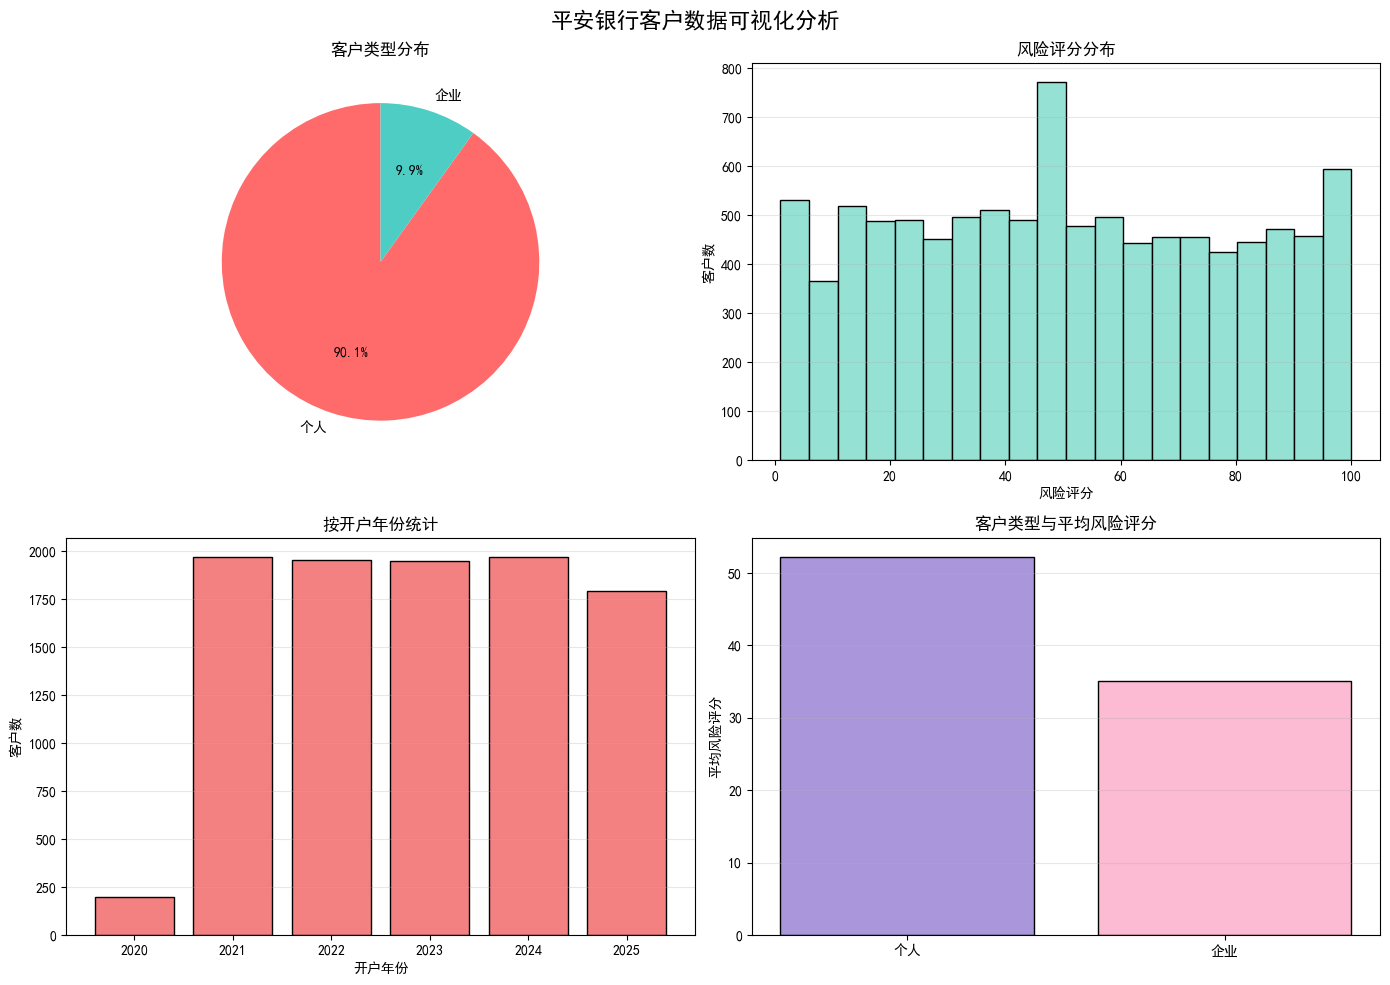

✓ 可视化完成！


In [6]:
# 1. 客户类型分布（饼图）
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('平安银行客户数据可视化分析', fontsize=16, fontweight='bold')

# 1.1 客户类型分布
customer_type_data = df_clean['customer_type'].value_counts()
colors = ['#FF6B6B', '#4ECDC4']
axes[0, 0].pie(customer_type_data.values, labels=customer_type_data.index, autopct='%1.1f%%', 
               colors=colors, startangle=90)
axes[0, 0].set_title('客户类型分布', fontsize=12, fontweight='bold')

# 1.2 风险评分分布（直方图）
axes[0, 1].hist(df_clean['risk_score'], bins=20, color='#95E1D3', edgecolor='black')
axes[0, 1].set_xlabel('风险评分', fontsize=10)
axes[0, 1].set_ylabel('客户数', fontsize=10)
axes[0, 1].set_title('风险评分分布', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# 1.3 按开户年份统计
year_data = df_clean['year_opened'].value_counts().sort_index()
axes[1, 0].bar(year_data.index, year_data.values, color='#F38181', edgecolor='black')
axes[1, 0].set_xlabel('开户年份', fontsize=10)
axes[1, 0].set_ylabel('客户数', fontsize=10)
axes[1, 0].set_title('按开户年份统计', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# 1.4 客户类型与风险评分关系
customer_type_risk = df_clean.groupby('customer_type')['risk_score'].mean()
axes[1, 1].bar(customer_type_risk.index, customer_type_risk.values, color=['#AA96DA', '#FCBAD3'], edgecolor='black')
axes[1, 1].set_ylabel('平均风险评分', fontsize=10)
axes[1, 1].set_title('客户类型与平均风险评分', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ 可视化完成！")

## 第6步：数据保存和导入数据库

In [7]:
# 保存清洁后的数据
print("=" * 60)
print("保存清洁数据...")
print("=" * 60)

file_path_clean = os.path.join(data_folder, 'pingan_bank_customers_clean.csv')
df_clean.to_csv(file_path_clean, index=False, encoding='utf-8-sig')
print(f"✓ 清洁数据已保存到: {file_path_clean}")
print(f"✓ 总记录数: {len(df_clean)}")


保存清洁数据...
✓ 清洁数据已保存到: Data\pingan_bank_customers_clean.csv
✓ 总记录数: 9836


In [ ]:

# 导入 MySQL 数据库
print("\n" + "=" * 60)
print("导入数据到 MySQL 数据库...")
print("=" * 60)

from sqlalchemy import create_engine

# 创建数据库连接
engine = create_engine("mysql+pymysql://root:@localhost:3306/mydb")

# 将清洁数据导入 MySQL
try:
    df_clean.to_sql(
        name='pingan_bank_customers', 
        con=engine,
        if_exists='replace',   # 第一次导入用 replace；之后可以改 append
        index=False
    )
    print("✓ 成功写入 MySQL 数据库！")
    print(f"✓ 表名: pingan_bank_customers")
    print(f"✓ 总记录数: {len(df_clean)}")
except Exception as e:
    print(f"❌ 数据库连接失败: {e}")
    print("提示: 请确保 MySQL 服务器正在运行，并且数据库 'mydb' 已创建")



# 接下来进入SQL1.sql文件中继续处理数据
# 拓展插件为SQL NoteBook
# 使用菜单选项打开任意.sql文件Open With
# 然后，选择文件SQL Notebook格式
# 在 SQL Notebook 侧面板中配置数据库连接


导入数据到 MySQL 数据库...
✓ 成功写入 MySQL 数据库！
✓ 表名: pingan_bank_customers
✓ 总记录数: 9836
✓ 成功写入 MySQL 数据库！
✓ 表名: pingan_bank_customers
✓ 总记录数: 9836
